In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

# Ensure the appropriate backend for Matplotlib based on your OS
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

# Import custom modules
import sys
sys.path.append(os.path.join(sys.path[0], '..'))
from metrics import evaluation_metrics
from metrics import cls_feature_class

# # Constants
# HOP_LENGTH_SECONDS = 0.02
# BASELINE = "output"
# DATE_ = '2023-09-28_22-26-44'

# # Define the class dictionary
# class_dict = {
#     'crane': 0,
#     'piledriver': 1,
#     'saw': 2,
#     'excavator': 3,
#     'pneumaticbreaker': 4,
#     'concretepumper': 5,
#     'forklift': 6
# }

# # Function to collect classwise data
# def collect_classwise_data(input_dict):
#     output_dict = {}
#     for key, values in input_dict.items():
#         for seld in values:
#             class_name = seld[0]
#             if class_name not in output_dict:
#                 output_dict[class_name] = []
#             output_dict[class_name].append([key, class_name, seld[1], seld[2]])
#     return output_dict

# # Function to plot data
# def plot_data(plot_data, hop_length_seconds, index, x_length, class_dict, plot_x_axis=False):
#     color_map = ['b', 'r', 'g', 'y', 'k', 'c', 'm']
#     for class_index, data_points in plot_data.items():
#         print(class_index, data_points)
#         time_axis = np.array(data_points)[:, 0] * hop_length_seconds
#         y_axis = np.array(data_points)[:, index]
#         label = list(class_dict.keys())[list(class_dict.values()).index(class_index)]
#         plt.plot(time_axis, y_axis, marker='.', color=color_map[class_index], linestyle='None', markersize=4, label=label)
#     plt.grid()
#     plt.xlim([-0.2, x_length])
#     if not plot_x_axis:
#         plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# def main(DATE, x_length):
#     pred_dir = DATE
#     aud_dir = f'{BASELINE}/audio/{DATE_}/'

#     # Get all the CSV files in the predicted directory
#     predicted_files = [os.path.join(pred_dir, f) for f in os.listdir(pred_dir) if f.endswith('.csv')]
#     print(predicted_files[2])

#     pred =  predicted_files[2]

#     x_length = x_length

#     pred_dict = evaluation_metrics.load_output_format_file(pred)
#     pred_data = collect_classwise_data(pred_dict)

#     # Load the reference output format
#     feat_cls = cls_feature_class.FeatureClass()
#     num_classes = len(feat_cls.get_classes())

#     # Load the audio and extract the spectrogram
#     pred_filename = os.path.basename(pred)
#     audio, fs = feat_cls._load_audio(os.path.join(aud_dir, pred_filename.split('.')[0]) + '.wav')
#     stft = np.abs(np.squeeze(feat_cls._spectrogram(audio[:, :1])))
#     stft = librosa.amplitude_to_db(stft, ref=np.max)

#     fig1 = plt.figure(figsize=(15, 10), constrained_layout=True)
#     gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)
#     plot_data(pred_data, HOP_LENGTH_SECONDS, index=2, x_length=x_length, class_dict=class_dict)
#     plt.ylim([-10, num_classes + 370])
#     plt.title('DOA Estimation')

#     # Add a legend
#     plt.legend()

#     # Display the plot
#     plt.show()

#     # Save the figure to a file in the "figures" directory
#     fig1.savefig(os.path.join(pred_dir, pred_filename.split('.')[0]))

In [2]:
# import wave, os, glob
# folder_list = []
# path = 'output/meta_plot/*/'

# for folder in glob.glob(path):
#     if os.path.isdir(folder):
#         folder_list.append(folder)


In [3]:
# # Sort the folder_paths list by creation time in descending order
# folder_list.sort(key=lambda x: os.path.getctime(x), reverse=True)

# last_created_folder = folder_list[0]

# print(last_created_folder)

# x_length = 11.5

# folder_list


In [10]:
# if __name__ == "__main__":
#     main(last_created_folder, x_length)

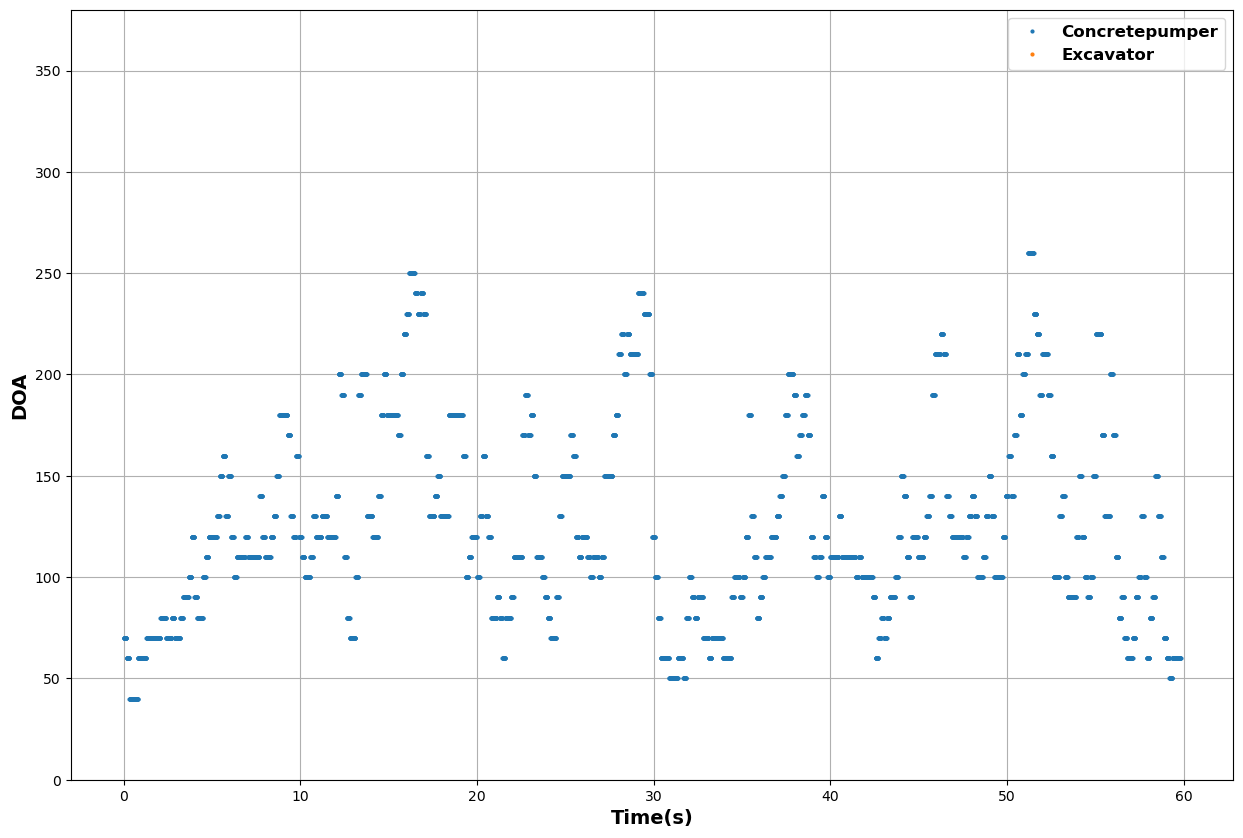

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

samplefile = '2023-10-02_14-42-41'

folder_dir = f'output/meta_plot/{samplefile}/split3_ID9_5_vs_3_doas.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(folder_dir, header=None)
df = df.round(decimals=-1)

# Define the class dictionary
class_dict = {
    0: 'Crane', 
    1: 'Piledriver', 
    2: 'Saw', 
    3: 'Excavator', 
    4: 'Pneumaticbreaker', 
    5: 'Concretepumper', 
    6: 'Forklift'
}

# Specify which two columns to plot (e.g., columns 0 and 1)
column1 = 5
column2 = 3


# Create a time variable (assuming time increments by 1 for each data point)
time = np.arange(df.shape[0])

time_axis = time * 0.01

# Create a figure and axis
fig1, ax = plt.subplots(figsize=(15, 10))

# Create a line plot for the selected columns
line1, = ax.plot(time_axis[:], df[column1][:], marker='.', linestyle='None', markersize=4)
line1.set_label(class_dict[column1])  # Set label for the line

# line2, = ax.plot(time_axis[500:], df[column2][500:], marker='.', linestyle='None', markersize=4)
# line2.set_label(class_dict[column2])  # Set label for the line

ax.grid()

# Set x-axis label properties (bold and increased font size)
ax.set_xlabel('Time(s)', fontweight='bold', fontsize=14)

# Set y-axis label properties (bold and increased font size)
ax.set_ylabel('DOA', fontweight='bold', fontsize=14)

# Set legend properties (bold and increased font size)
ax.legend(handles=[line1, line2], labels=[class_dict[column1], class_dict[column2]], prop={'weight': 'bold', 'size': 12})
# ax.legend(handles=[line1, line2], labels=[class_dict[column2]], prop={'weight': 'bold', 'size': 12})

# Set the y-axis range (length)
ax.set_ylim(0, 380)  # Adjust the lower and upper limits as needed


# Save the figure to a file in the "figures" directory
fig1.savefig(folder_dir.split('.')[0])

# Show the plot
plt.show()
